In [1]:
# Import all the .py files and necessary libraries
import torch
from PIL import Image
from dataloader import load_data, augment_data, get_item, custom_collate, OCTDataset
from model import ConvNet
from transforms import composedTransform, identityTransform
from loss import sim_matrix, pair_loss_matrix, total_contrastive_loss
from train import predict, train_one_step, train_one_epoch, train
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt

/Users/hairanliang/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/hairanliang/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/hairanliang/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


I will walkthrough my self-supervised contrastive learning pipeline. Firstly, I will be using 4 arbitary OCT retinal images. I stored them in a list, which my Dataset and DataLoader will use to input it into the training loop.

In [2]:
image_list = ['/Users/hairanliang/Downloads/NORMAL-6477461-4.jpeg', 
               '/Users/hairanliang/Downloads/NORMAL-3767173-12.jpeg', 
             '/Users/hairanliang/Downloads/NORMAL-9453329-20.jpeg',
              '/Users/hairanliang/Downloads/NORMAL-7021113-21.jpeg',]

small_list = ['/Users/hairanliang/Downloads/NORMAL-6477461-4.jpeg', 
               '/Users/hairanliang/Downloads/NORMAL-3767173-12.jpeg']

Let's first see what one of these images looks like as well as its dimensions, which will be something we have to consider when inputting it into our CNN model.

In [3]:
image = Image.open('/Users/hairanliang/Downloads/NORMAL-6477461-4.jpeg')
print(image.format)
print(image.size)
print(image.mode) # L = 8-bit pixels, grayscale
# image.show()

JPEG
(512, 496)
L


Now, I will test my Dataset/DataLoader classes to make sure my custom collate_fn and Dataset classes work as intended. The special part of my Dataset class is that it has two modes specifically for getitem: augmentation mode and default mode. For augmentation mode (augmentation=True), my Dataset class takes in an image link and then returns two augmented versions of the image, whereas in default mode (augmentation=False), getitem will just return back the image albeit resized. 

In [4]:
dataset = OCTDataset(image_list, True) # augmentation mode

In [5]:
len(dataset) # This is correct: there are four image links and thus 4 original images in the Dataset (pre-augmentation).

4

The following is an example of an augmented image.

In [6]:
transform = T.ToPILImage()
img = transform(dataset[0][0])
# img.show() 

/Users/hairanliang/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


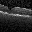

In [7]:
img

Now I will test my custom collate_fn using the DataLoader class. 

In [8]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=custom_collate)

Now, I want to see what a batch looks like. Since I set batch_size to 2, and I know there should be 4 images x 2 augmented images / image = 8 augmented images in total, then each batch should have 4 augmented images in the form of tensors.

In [9]:
batchTest = next(iter(dataloader))
print(batchTest.shape) 

torch.Size([4, 1, 32, 32])


In [10]:
transform = T.ToPILImage()
img = transform(batchTest[0])

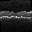

In [11]:
img

The shape of 4 x 1 x 32 x 32 makes sense: 4 augmented images (per batch), 1 for the grayscale channel, and 100 x 100 since my composed transformation makes does a resized crop into a 32 x 32 for all augmented images.

To see what each batch index and sample of augmented images looks like, I can do this:

In [12]:
for batch_idx, batch in enumerate(dataloader):
    print(batch_idx, batch)

0 tensor([[[[0.0066, 0.0111, 0.0200,  ..., 0.0307, 0.0107, 0.0043],
          [0.0181, 0.0232, 0.0341,  ..., 0.0388, 0.0162, 0.0079],
          [0.0445, 0.0506, 0.0641,  ..., 0.0589, 0.0295, 0.0162],
          ...,
          [0.0072, 0.0126, 0.0246,  ..., 0.0214, 0.0173, 0.0142],
          [0.0040, 0.0089, 0.0195,  ..., 0.0108, 0.0070, 0.0047],
          [0.0024, 0.0070, 0.0168,  ..., 0.0056, 0.0027, 0.0011]]],


        [[[0.3359, 0.3570, 0.4211,  ..., 0.2579, 0.2577, 0.2550],
          [0.3268, 0.3456, 0.4047,  ..., 0.2574, 0.2565, 0.2537],
          [0.2968, 0.3177, 0.3749,  ..., 0.2707, 0.2720, 0.2696],
          ...,
          [0.0254, 0.0268, 0.0334,  ..., 0.0359, 0.0327, 0.0326],
          [0.0224, 0.0244, 0.0344,  ..., 0.0393, 0.0356, 0.0366],
          [0.0255, 0.0257, 0.0357,  ..., 0.0411, 0.0380, 0.0397]]],


        [[[0.0040, 0.0073, 0.0145,  ..., 0.0245, 0.0100, 0.0059],
          [0.0113, 0.0156, 0.0245,  ..., 0.0331, 0.0147, 0.0087],
          [0.0266, 0.0326, 0.0455,  

Now the last thing to do is test if my dataloader synergizes with my training loop. First, I will show the training functions and that they work fine. After, I will show a little bit about what's going on underneath the hood.

In [13]:
# Testing to see if manually giving a list will lead to training that works

# ['/Users/hairanliang/Downloads/NORMAL-6477461-4.jpeg', 
#                '/Users/hairanliang/Downloads/NORMAL-3767173-12.jpeg', 
#              '/Users/hairanliang/Downloads/NORMAL-9453329-20.jpeg',
#               '/Users/hairanliang/Downloads/NORMAL-7021113-21.jpeg',]

a = get_item('/Users/hairanliang/Downloads/NORMAL-6477461-4.jpeg')
b = get_item('/Users/hairanliang/Downloads/NORMAL-3767173-12.jpeg')
c = get_item('/Users/hairanliang/Downloads/NORMAL-9453329-20.jpeg')
d = get_item('/Users/hairanliang/Downloads/NORMAL-7021113-21.jpeg')

In [14]:
ab = torch.vstack((a,b))
cd = torch.vstack((c,d))

In [15]:
ab.shape

torch.Size([2, 32, 32])

In [16]:
cd.shape

torch.Size([2, 32, 32])

In [17]:
test_list = [ab, cd]

In [19]:
# Initializing the ConvNet Model
model = ConvNet()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
# train_one_step(batch, model, optimizer)

In [21]:
# train_one_epoch(dataloader, model, optimizer)

In [22]:
# train(dataloader, model, optimizer, 1000)

In [23]:
loss_history = train(dataloader, model, optimizer, 1000)

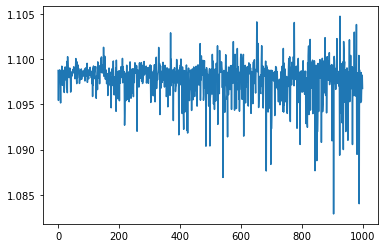

In [24]:
plt.plot(loss_history)

In [64]:
print(model) # Do pooling instead of flattening 

ConvNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
)


As can be seen, all of my train functions work well. Train_one_step only takes in a batch of data whereas train_one_epoch and train take in the entire dataloader. The loss starts at around 3.1, and with training 50 epochs, the model gets to a loss of 2.1, which is pretty good and shows that the model is learning (and likely overfitting due to how small the training set is).

Now the last thing I want to show is how the model's outputs, loss, similarity matrix, and so on change over time. To do this, I will take out of the abstraction into functions and just code everything into code blocks that can be re-run over and over to see how the loss changes after each run through. I will use only two images(4 augmented images), which is the minimum for contrastive learning, for this demonstration. 

In [62]:
# Demonstration that lets us see how the values evolve over time during training

# get_item function is now coded out to see all the different parts separately
aug_list_1 = []
aug_list_2 = []
test_list_1 = ['/Users/hairanliang/Downloads/NORMAL-6477461-4.jpeg', 
               '/Users/hairanliang/Downloads/NORMAL-3767173-12.jpeg']
test_list_2 = ['/Users/hairanliang/Downloads/NORMAL-9453329-20.jpeg',
              '/Users/hairanliang/Downloads/NORMAL-7021113-21.jpeg']
for link in test_list_1:
    x = load_data(link)
    aug_x1 = augment_data(x, True)
    aug_x2 = augment_data(x, True)
    aug_list_1.extend([aug_x1, aug_x2])
aug_tensor_1 = torch.stack(aug_list_1, dim=0)

for link in test_list_2:
    x = load_data(link)
    aug_x1 = augment_data(x, True)
    aug_x2 = augment_data(x, True)
    aug_list_2.extend([aug_x1, aug_x2])
aug_tensor_2 = torch.stack(aug_list_2, dim=0)

In [63]:
aug_tensor_1.type

<function Tensor.type>

In [64]:
aug_tensor_1.shape

torch.Size([4, 1, 32, 32])

In [120]:
testModel = ConvNet()
test_learning_rate = 0.1
test_optimizer = torch.optim.SGD(testModel.parameters(), lr=test_learning_rate)

In [143]:
outputs = testModel(aug_tensor_1)
simi_matrix = sim_matrix(outputs)
pair_matrix = pair_loss_matrix(simi_matrix)
loss = total_contrastive_loss(pair_matrix)
test_optimizer.zero_grad()
loss.backward()
test_optimizer.step()

In [144]:
loss

tensor(1.0987, grad_fn=<MulBackward0>)

In [145]:
loss.requires_grad

True

In [146]:
simi_matrix

tensor([[1.0000, 0.9995, 0.9997, 0.9996],
        [0.9995, 1.0000, 0.9997, 0.9985],
        [0.9997, 0.9997, 1.0000, 0.9991],
        [0.9996, 0.9985, 0.9991, 1.0000]], grad_fn=<DivBackward0>)

In [61]:
pair_matrix

tensor([[1.6093, 1.6093, 1.6094, 1.6093, 1.6096, 1.6095],
        [1.6092, 1.6091, 1.6095, 1.6093, 1.6097, 1.6096],
        [1.6094, 1.6097, 1.6093, 1.6093, 1.6094, 1.6094],
        [1.6094, 1.6096, 1.6094, 1.6093, 1.6094, 1.6094],
        [1.6095, 1.6098, 1.6093, 1.6093, 1.6092, 1.6092],
        [1.6095, 1.6098, 1.6093, 1.6093, 1.6093, 1.6093]],
       grad_fn=<PermuteBackward0>)

As can be seen, the loss continuously goes down, and we can also see the values in both the similarity matrix and pair matrix change, representing how the positive pairs get closer together and get further away from negative pairs as the loss goes down. 

What still needs to be done: 1. Understanding why the larger neural network does not work when it comes to calculating the similarity matrix (I get weird outputs). 
2. Experimenting with large OCT data to see what hyperparameters work best, such as how many layers for CNN, how many neurons in each convolutional layer, learning rate, etc. (Use ResNet-18)

In [13]:
a = load_data('/Users/hairanliang/Downloads/NORMAL-6477461-4.jpeg')
a_tensor = augment_data(a)
a_tensor

tensor([[[0.0569, 0.0588, 0.0294,  ..., 0.0941, 0.1333, 0.0642],
         [0.1142, 0.0015, 0.1578,  ..., 0.0711, 0.1608, 0.1304],
         [0.0069, 0.1162, 0.0529,  ..., 0.1873, 0.1235, 0.0520],
         ...,
         [0.0377, 0.0368, 0.0225,  ..., 0.0225, 0.0284, 0.0358],
         [1.0000, 1.0000, 1.0000,  ..., 0.0191, 0.0093, 0.0074],
         [1.0000, 1.0000, 1.0000,  ..., 0.0211, 0.0368, 0.0265]]])

In [1]:
import matplotlib.pyplot as plt

In [5]:
a = [5, 6, 7]
flip = 'burger'

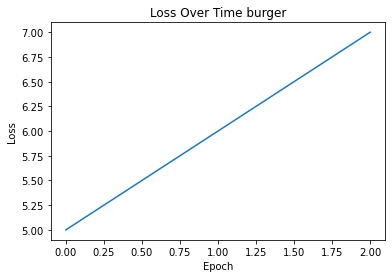

In [8]:
plt.plot(a)
plt.title('Loss Over Time ' + flip)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()